# Data Anaylst Tech Challenge
## Douglas Lawton


In [2]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotnine as pn

from tabulate import tabulate

# Data loading and inspection

Lets load in all the data and take a peak at them, looking for errors and just to get a feel for the data.

In [12]:
census_tract_data = gpd.read_parquet('data/census_tract_data.parquet')
protest_data = pd.read_parquet('data/protest_data.parquet')

print('census_tract_data')
census_tract_data.head(3)

print('protest_data')
protest_data.head(3)

census_tract_data
protest_data


,date,lat,lon,type,actors,arrests_any,property_damage_any,source_1
0,2021-01-01,32.379223,-86.307739,strike; boycott,Free Alabama Movement; prisoners,0,0,https://sfbayview.com/2020/12/fam-launches-30-...
1,2021-01-01,37.885757,-122.118019,demonstration,Contra Costa County Patriots,0,0,https://www.sfgate.com/news/bayarea/article/Co...
2,2021-01-01,37.441883,-122.143021,vigil,WILPF,0,0,https://www.facebook.com/PPAWILPF/


I found some NA values in `protest_data` lat/lon columns. I just dropped them as they wont have any use for us

In [13]:
# Looking at non-numeric rows
print('what are the non-numeric rows')
protest_data[pd.isna(protest_data['lat']) | pd.isna(protest_data['lon'])]


protest_data[['lon', 'lat']] = protest_data[['lon', 'lat']].apply(pd.to_numeric, errors='coerce')
protest_data = gpd.GeoDataFrame(protest_data, geometry=gpd.points_from_xy(protest_data['lon'], protest_data['lat']), crs="EPSG:4326")

what are the non-numeric rows


I'm quickly plotting both datasets to ensure everything looks okay.

<Axes: >

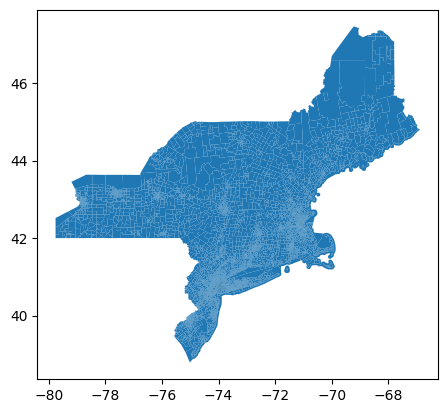

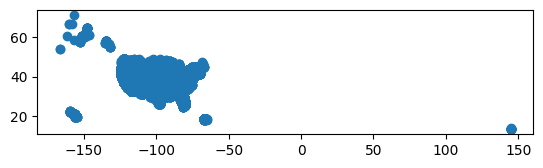

In [14]:
census_tract_data.plot()

protest_data.plot()

Alright most things look okay. I am assuming that the lat/long coords are WGS84.

The `protest_data` has a weird point around 150 latitude. This looks like an incorrect cordinate that should be in hawaii (unless Hawaii stretches that far). I'll keep this in mind if it becomes a problem


# Question 1a

#### Writing a function labeled `clean_protest_data` to clean a pandas dataframe

In [15]:
def clean_protest_data(data, year_list, non_null_columns_list, within_geometry_gdf):
    """
    Clean a pandas dataframe based on specified parameters.

    Parameters:
    - data: pd.DataFrame
        The protest dataframe to clean.
    - year_list: list
        Reduce the dataframe to years in this list.
    - non_null_columns_list: list
        Reduce the dataframe to only rows that have non-null values for all columns in the list.
    - within_geometry_gdf: gpd.GeoDataFrame
        Reduce the dataframe to rows that are within the geometry of this GeoDataFrame.
        Only use the 'us_census_geo_id' and 'geometry' columns from this geodataframe, and remove 'geometry', 'lat', 'lon' after validating the geometry.

    Returns:
    - pd.DataFrame
        A cleaned pandas dataframe with specified columns.
    """
    # Filter dataframe based on year_list
    data = data[data['date'].dt.year.isin(year_list)]

    # Filter dataframe to only rows with non-null values for specified columns
    data = data.dropna(subset=non_null_columns_list, how='all')

    # Validate and clean geometry in within_geometry_gdf
    within_geometry_gdf = within_geometry_gdf[['us_census_geo_id', 'geometry']]
    within_geometry_gdf = within_geometry_gdf[within_geometry_gdf['geometry'].is_valid]

    # Merge data with within_geometry_gdf based on geometry
    data = gpd.sjoin(data, within_geometry_gdf, how='inner', predicate='within')

    # Remove unnecessary columns from within_geometry_gdf
    data.drop(['geometry', 'lat', 'lon'], axis=1, inplace=True)

    # Return the cleaned dataframe with specified columns
    return data[['date', 'type', 'actors', 'arrests_any', 'property_damage_any', 'source_1', 'us_census_geo_id']]



# Question 1b

#### Filtering protest data for what falls within the census data

Should be self explanatory, I use the criteria given in the challenge

In [16]:
data = protest_data
year_list = [2021]
non_null_columns_list = ['date', 'lat', 'lon', 'type', 'arrests_any', 'property_damage_any','source_1']
within_geometry_gdf = census_tract_data[['us_census_geo_id', 'geometry']]

cleaned_protest_data = clean_protest_data(data,year_list,non_null_columns_list,within_geometry_gdf)
cleaned_protest_data

,date,type,actors,arrests_any,property_damage_any,source_1,us_census_geo_id
19,2021-01-01,demonstration,Longmeadow Anti-Racist Coalition,0,0,https://www.masslive.com/news/2023/06/dueling-...,25013813301
20,2021-01-01,demonstration,Fridays for Future Wellesley,0,0,https://www.facebook.com/groups/490225741689717,25021404400
22,2021-01-01,vigil,Women in Black; Veterans for Peace,0,0,https://www.sunjournal.com/2022/02/10/farmingt...,23007971202
25,2021-01-01,demonstration,Fridays for Future Jaffrey,0,0,https://www.facebook.com/groups/813917632784030,33005970500
26,2021-01-01,demonstration,Verona for Black Lives Matter,0,0,https://twitter.com/protest_nyc/status/1345085...,34003023100
...,...,...,...,...,...,...,...
28911,2021-12-31,vigil; march,Upper East Side for Black Lives Matter,0,0,https://www.instagram.com/p/CUgDSgGF5Fr/?utm_s...,36061003100
28912,2021-12-31,rally,1000 People 1000 Trees,0,0,https://twitter.com/protest_nyc/status/1477023...,36061003100
28913,2021-12-31,vigil,None,0,0,https://www.instagram.com/p/CRzHs47D8fG/?utm_s...,36061003100
28914,2021-12-31,demonstration,NYC Anarchist Black Cross; Uptown Revolutionar...,0,0,https://nycabc.wordpress.com/2021/12/18/nye2021/,36061003100


# Question 2

#### What percent of counties from 'census_tract_data.parquet' have 0 protest events?

The data is in long format with each event given a date and a row. For simplicity (and since we dont care about date or protest type at this point), lets start by just counting up the number of protests that happens in each `us_census_geo_id`regardless of type or date

In [17]:
number_protests_by_geo_id = cleaned_protest_data.groupby('us_census_geo_id').size().reset_index(name='number_of_protest')
number_protests_by_geo_id.head(2)

,us_census_geo_id,number_of_protest
0,09001010600,7
1,09001020102,5


The protest data does not have state and county information, so I'll need to join the census data.

I need to ensure that we do not filter out counties without protests as this is where the 0 protest data will come from

So I'll see how many `us_census_geo_id` there are and count them up. The resulting merged dataset should have exactly the same number of `us_census_geo_id` as `census_tract_data`


In [18]:
protest_geo_ids = np.unique(number_protests_by_geo_id.us_census_geo_id)
census_geo_ids = np.unique(census_tract_data.us_census_geo_id)

print(f'Number of us_census_geo_id in protest data: {len(protest_geo_ids)}')
print(f'Number of us_census_geo_id in census data: {len(census_geo_ids)}')


Number of us_census_geo_id in protest data: 637
Number of us_census_geo_id in census data: 11295


In [19]:
state_county_ids = census_tract_data[['state_name','county_name','us_census_geo_id']]


protests_by_state_county = pd.merge(number_protests_by_geo_id, census_tract_data,
                                    on='us_census_geo_id', how='right')

protest_geo_ids = np.unique(number_protests_by_geo_id.us_census_geo_id)
census_geo_ids = np.unique(census_tract_data.us_census_geo_id)
merged_geo_ids = np.unique(protests_by_state_county.us_census_geo_id)
                           
print(f'Number of us_census_geo_id in protest data: {len(protest_geo_ids)}')
print(f'Number of us_census_geo_id in census data: {len(census_geo_ids)}')
print(f'Number of us_census_geo_id in merged data: {len(merged_geo_ids)}')

Number of us_census_geo_id in protest data: 637
Number of us_census_geo_id in census data: 11295
Number of us_census_geo_id in merged data: 11295


Great -- good sanity check.

Now I have a bunch of NaNs which represent zeros (no protests). Lets fill them in with 0

In [20]:
protests_by_state_county['number_of_protest'] = protests_by_state_county['number_of_protest'].fillna(0)

protests_by_state_county.head(5)

,us_census_geo_id,number_of_protest,state_name,county_name,internal_lat,internal_lon,land_area_meters_squared,population_2021,geometry
0,09001010101,0.0,Connecticut,Fairfield,41.084084,-73.682022,32765658.0,4391,"POLYGON ((-73.72777 41.10070, -73.71376 41.107..."
1,09001010102,0.0,Connecticut,Fairfield,41.105015,-73.641899,32619576.0,4136,"POLYGON ((-73.67013 41.12207, -73.67012 41.122..."
2,09001010201,0.0,Connecticut,Fairfield,41.064205,-73.620239,11255057.0,3501,"POLYGON ((-73.65501 41.06846, -73.65449 41.068..."
3,09001010202,0.0,Connecticut,Fairfield,41.069126,-73.592293,9845917.0,5743,"POLYGON ((-73.60706 41.05342, -73.60704 41.053..."
4,09001010300,0.0,Connecticut,Fairfield,41.037346,-73.640686,9636411.0,4137,"POLYGON ((-73.66470 41.03898, -73.66450 41.039..."


Now I want to group by state and county and calculate the percent

In [21]:
# Group by 'state_name' and 'county_name' and calculate the mean of 'number_of_protest'
state_count_avg_protests = protests_by_state_county.groupby(['state_name', 'county_name'])['number_of_protest'].sum().reset_index()

zero_count = (state_count_avg_protests['number_of_protest'] == 0).sum()
total_rows = total_rows = len(state_count_avg_protests)

percentage_zero_protest = (zero_count / total_rows) * 100

print(f"Percentage of unique counties with zero protests: {percentage_zero_protest:.2f}%")


Percentage of unique counties with zero protests: 9.33%


# Question 3

#### What are the quintile bands of county protest events for counties with at least 1 protest event?

In [22]:
non_zero_protest_counties = state_count_avg_protests[state_count_avg_protests.number_of_protest>=1]
quintiles = non_zero_protest_counties['number_of_protest'].quantile([0, 0.20, 0.4, 0.6, 0.8,1.0])

In [23]:

table_data = [
    ["0% - 20%", f"{quintiles.loc[0.00]:.2f} - {quintiles.loc[0.2]:.2f}"],
    ["20% - 40%", f"{quintiles.loc[0.2]:.2f} - {quintiles.loc[0.4]:.2f}"],
    ["40% - 60%", f"{quintiles.loc[0.4]:.2f} - {quintiles.loc[0.6]:.2f}"],
    ["60% - 80%", f"{quintiles.loc[0.6]:.2f} - {quintiles.loc[0.8]:.2f}"],
    ["80% - 100%", f"{quintiles.loc[0.8]:.2f} - {quintiles.loc[1.0]:.2f}"]
]

print("Quintile Bands:")
print(tabulate(table_data, headers=["Quintile Range", "Values"], tablefmt="pretty"))


Quintile Bands:
+----------------+-----------------+
| Quintile Range |     Values      |
+----------------+-----------------+
|    0% - 20%    |   1.00 - 2.00   |
|   20% - 40%    |   2.00 - 6.00   |
|   40% - 60%    |  6.00 - 13.00   |
|   60% - 80%    |  13.00 - 60.00  |
|   80% - 100%   | 60.00 - 2557.00 |
+----------------+-----------------+


Out of curiosity -- what does the histogram of protests look like?

In [24]:
def plot_histogram(data, column, bins=20, color='blue', edgecolor='black', log_transform=False):
    """
    Plot a histogram for a given column in the DataFrame.

    Parameters:
    - data: DataFrame
        The DataFrame containing the data.
    - column: str
        The column for which the histogram will be plotted.
    - bins: int, optional (default=20)
        Number of bins in the histogram.
    - color: str, optional (default='blue')
        Color of the histogram bars.
    - edgecolor: str, optional (default='black')
        Color of the edges of the bars.
    - log_transform: bool, optional (default=False)
        Whether to log-transform the data before plotting.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))

    if log_transform:
        log_column_name = f'log_{column}'
        data.loc[:, log_column_name] = np.log1p(data[column])
        plt.hist(data[log_column_name], bins=bins, color=color, edgecolor=edgecolor)
        plt.xlabel(f'Log({column})')
        plt.title(f'Histogram of Log-Transformed {column}')
    else:
        plt.hist(data[column], bins=bins, color=color, edgecolor=edgecolor)
        plt.xlabel(column)
        plt.title(f'Histogram of {column}')

    plt.ylabel('Frequency')
    plt.show()




Lets plot both the raw data and logged transformed data -- I have a feeling its going to be a heavily skewed dataset

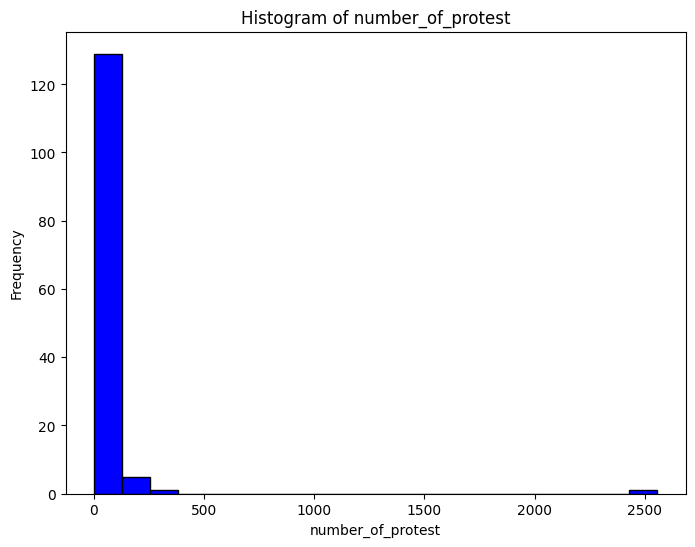

/var/folders/by/_2g6r6b55xv6d648248h0j600000gq/T/ipykernel_21737/2999082135.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


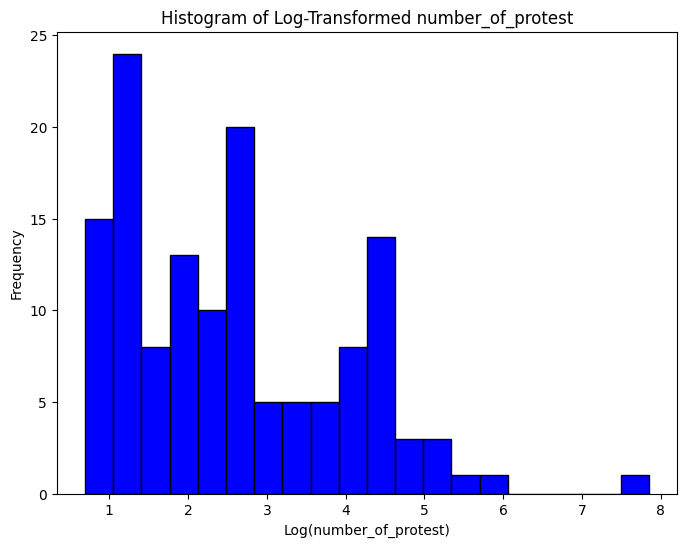

In [25]:
plot_histogram(non_zero_protest_counties, 'number_of_protest', log_transform=False)
plot_histogram(non_zero_protest_counties, 'number_of_protest', log_transform=True)

interesting but not totally unexpected -- many counties have few protests, few counties have a bunch. We can see the decay better in the logged-transformed graph.

# Question 4a

#### Please create a map visualization of the top 20 census tracks of protest events per capita.

#### Feel free to use the census tract polygons or lat/lon coordinates to represent the geometry.

#### Please title your visualization and color the geometry by protest events per capita. Please save a screenshot of your map called 'top_protest_census_tracts.png'

Sanity check -- are there any geo_ids with more than one row?

In [26]:
protests_by_state_county['us_census_geo_id'].duplicated().any()

False


Lets find the top 20 census tracks of protest events per captia. Note not counties -- but census tracts

I'll use the protests_by_state_county dataframe since it has the us_census_geo_id information

In [27]:
protests_by_state_county['protests_per_capita'] = protests_by_state_county['number_of_protest'] / protests_by_state_county['population_2021']

top_20_census = protests_by_state_county.sort_values(by='protests_per_capita', ascending=False).head(20)

top_20_census = gpd.GeoDataFrame(top_20_census, geometry='geometry')

top_20_census.head(5)

,us_census_geo_id,number_of_protest,state_name,county_name,internal_lat,internal_lon,land_area_meters_squared,population_2021,geometry,protests_per_capita
8046,36061003100,2557.0,New York,New York,40.715309,-74.003815,204969.0,2684,"POLYGON ((-74.00860 40.71139, -74.00810 40.712...",0.952683
2811,25027731700,324.0,Massachusetts,Worcester,42.263817,-71.800385,1258338.0,3594,"POLYGON ((-71.80797 42.25889, -71.80738 42.259...",0.090150
2531,25025030302,205.0,Massachusetts,Suffolk,42.360142,-71.057724,477388.0,2399,"POLYGON ((-71.06291 42.36123, -71.06276 42.361...",0.085452
6483,36029016500,148.0,New York,Erie,42.884598,-78.873024,1905218.0,1921,"POLYGON ((-78.88019 42.88523, -78.88006 42.885...",0.077043
5454,36001001100,91.0,New York,Albany,42.652554,-73.750061,1740188.0,1988,"POLYGON ((-73.76327 42.65015, -73.76262 42.650...",0.045775


Obviously theres a huge outlier here. New York county had ~2,500 protests and a population of ~ 2,700. This is going to make mapping a little difficult as color ramps will be thrown off.

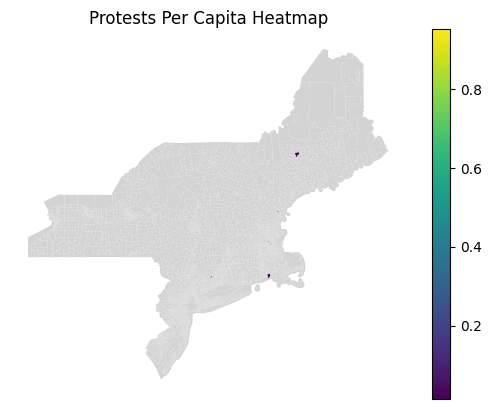

In [28]:
# Plot the base map with protests_by_state_county
gdf_protests = gpd.GeoDataFrame(protests_by_state_county, geometry='geometry')
ax = gdf_protests.plot(color='lightgrey')

# Plot the color heatmap for top_20_census
top_20_census.plot(column='protests_per_capita', cmap='viridis', linewidth=0.8, ax=ax, legend=True)

# Add a legend
legend = ax.get_legend()

# Set axis labels and title
ax.set_title('Protests Per Capita Heatmap')
ax.axis('off')

# display and save map
plt.show()

okay the census tracts are very small...there is an obvious outlier with new york and thats messing up the color ramp. 


Lets convert over to points (instead of the specific census geometry) for clarity sake. I will also put the response on a log scale -- maybe this will be enough

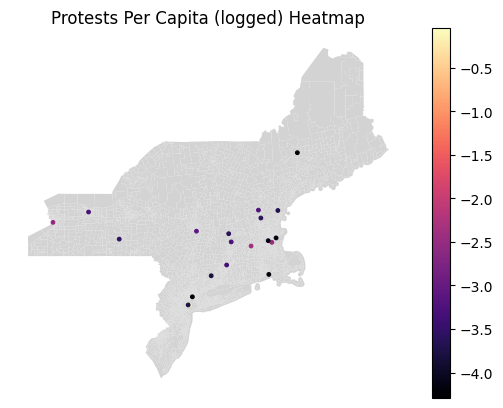

In [29]:
# creating a geopandas dataframe from lat/lon for point data instead of polygons
top_20_census_points = gpd.GeoDataFrame(top_20_census, geometry=gpd.points_from_xy(top_20_census.internal_lon, top_20_census.internal_lat))
top_20_census_points['protests_per_capita_logged'] = np.log(top_20_census.protests_per_capita)


# Plot the base map with protests_by_state_county
gdf_protests = gpd.GeoDataFrame(protests_by_state_county, geometry='geometry')
ax = gdf_protests.plot(color='lightgrey')

# Plot the color heatmap for top_20_census
top_20_census_points.plot(column='protests_per_capita_logged', cmap='magma', linewidth=0.8, ax=ax, legend=True,s=7)

# Add a legend
legend = ax.get_legend()

# Set axis labels and title
ax.set_title('Protests Per Capita (logged) Heatmap')
ax.axis('off')


plt.show()

Alright, we could make this map better -- New York is really skewing the color ramp. But at least you can see a color difference.

My last map will use winsorizing. This will allow us show the differences in the data without removing the outlier. Of course there is nuances here -- we are modifying the data. But at least we can see where protests are more likely to occur.

In [30]:
# Defining percentiles and thresholds for winsorizing
lower_percentile = 5
upper_percentile = 95

lower_threshold = np.percentile(top_20_census_points['protests_per_capita'], lower_percentile)
upper_threshold = np.percentile(top_20_census_points['protests_per_capita'], upper_percentile)

# Winsorize data
top_20_census_points['events_per_capita_winsorized'] = np.clip(top_20_census_points['protests_per_capita'], lower_threshold, upper_threshold)

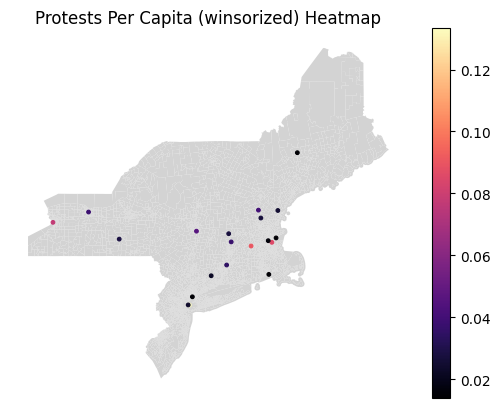

In [31]:
# Plot the base map with protests_by_state_county
gdf_protests = gpd.GeoDataFrame(protests_by_state_county, geometry='geometry')
ax = gdf_protests.plot(color='lightgrey')

# Plot the color heatmap for top_20_census
top_20_census_points.plot(column='events_per_capita_winsorized', cmap='magma', linewidth=0.8, ax=ax, legend=True,s=7)

# Add a legend
legend = ax.get_legend()

# Set axis labels and title
ax.set_title('Protests Per Capita (winsorized) Heatmap')
ax.axis('off')

# display and save map
plt.savefig('./output/top_protest_census_tracts.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

Visually, I dont think the legend is at all needed, but i'll keep it just incase you all are interested.

# Question 4b

#### Do you think events per capita is a good metric for protest concentration across the US? (2-4 sentences)


It really depends on the use case and spatial scale. For across the US, I would say no as turning the numer of protests into percentage can bias the results. An extreme example would be a very small census tract that has an equal amount of protests -- this would bias the percentage and make it seem like this city is a hotbed of protest activity. This is an inherent issue when you convert data into ratios! 



# Question 5

#### How do the protest event types compare between Boston and Manhattan? (Use Suffolk county in Massachusetts for Boston and New York county in New York for Manhattan)

#### Please include at least one chart and a 3-5 sentence summary. Please save chart screenshot(s) like 'comparision_chart_1.png'

#### Hint: remember that one protest event can have multiple event types.

Alright we need to filter out the data for specific counties in two states. Problem is there is a Suffolk County in New York. To get around this, I just create a concat column called `state_county` and filter for the specific state/county combination

In [32]:

# Creating concatate columns
protests_by_state_county['state_county'] = protests_by_state_county['state_name'] + '_' + protests_by_state_county['county_name']

#Filter for the specific counties
two_counties_comparison = protests_by_state_county[
    protests_by_state_county['state_county'].isin(['New York_New York', 'Massachusetts_Suffolk'])
]

two_counties_comparison

,us_census_geo_id,number_of_protest,state_name,county_name,internal_lat,internal_lon,land_area_meters_squared,population_2021,geometry,protests_per_capita,state_county
2484,25025000101,0.0,Massachusetts,Suffolk,42.360878,-71.133049,249924.0,1824,"POLYGON ((-71.13660 42.36016, -71.13633 42.360...",0.0,Massachusetts_Suffolk
2485,25025000102,0.0,Massachusetts,Suffolk,42.359081,-71.143990,1067435.0,3706,"POLYGON ((-71.16090 42.35863, -71.16049 42.358...",0.0,Massachusetts_Suffolk
2486,25025000201,0.0,Massachusetts,Suffolk,42.354065,-71.161171,599227.0,4309,"POLYGON ((-71.16782 42.35328, -71.16775 42.353...",0.0,Massachusetts_Suffolk
2487,25025000202,0.0,Massachusetts,Suffolk,42.352604,-71.154343,601636.0,4094,"POLYGON ((-71.16057 42.35267, -71.16018 42.352...",0.0,Massachusetts_Suffolk
2488,25025000301,0.0,Massachusetts,Suffolk,42.354145,-71.168823,571431.0,2827,"POLYGON ((-71.17480 42.35051, -71.17475 42.350...",0.0,Massachusetts_Suffolk
...,...,...,...,...,...,...,...,...,...,...,...
8319,36061030900,0.0,New York,New York,40.875847,-73.910370,302756.0,11753,"POLYGON ((-73.91517 40.87570, -73.91513 40.875...",0.0,New York_New York
8320,36061031100,0.0,New York,New York,40.846748,-73.929680,730773.0,0,"POLYGON ((-73.94037 40.83147, -73.94035 40.831...",NaN,New York_New York
8321,36061031703,0.0,New York,New York,40.716766,-74.015594,248049.0,6419,"POLYGON ((-74.02427 40.71394, -74.02413 40.714...",0.0,New York_New York
8322,36061031704,0.0,New York,New York,40.706570,-74.018143,225043.0,10558,"POLYGON ((-74.02529 40.70726, -74.02513 40.708...",0.0,New York_New York


Now I merge `two_counties_comparison` to the protest data. I drop NAs in protest types as we are focusing on differences due to protest types

In [33]:

boston_ny_protests = (two_counties_comparison. 
    merge(cleaned_protest_data, on='us_census_geo_id', how='left'). 
    dropna(subset=['type']))


Since an event can have multiple protest types, I split it (on `;`) and `explode` out so that each protest gets a row.

In [34]:
boston_ny_protests['type'] = boston_ny_protests['type'].str.split(';')
boston_ny_protests = boston_ny_protests.explode('type')   

Lets see how many protest types there are:

In [35]:
boston_ny_protests['type'].nunique()

56

with 56 unique protest types, that makes visualizations challenging in a static graph. 

There also appears to be some weird special characters that are messing up our counts. Lets fix that by just getting letters.

In [36]:
boston_ny_protests['type'] = boston_ny_protests['type'].str.replace(r'[^a-zA-Z]', '', regex=True)

boston_ny_protests[['type','number_of_protest']].groupby('type').count()


,number_of_protest
type,
bannerdrop,23
bicycleride,17
bikeride,4
boycott,1
caravan,21
carrally,1
counterprotest,41
demonstration,388
diein,1


also lets combine bicycle and bike ride together since these two are obviously the same thing. I suppose bike could mean motorcycle -- but thats getting in the weeds here.

There are other protest types that are likely the same aswell but they are not as obvious. For now lets treat them separate

In [37]:
boston_ny_protests['type'] = boston_ny_protests['type'].replace('bikeride', 'bicycleride')

After correcting for the weird characters and combining bicycle rides, how many protest types do we have now?

In [38]:
boston_ny_protests['type'].nunique()

33

Still a lot for visualizations -- but could be worse

## First lets look at the correlation between number of specific protest types between the cities

I am interested in see if there isa 1:1 trend between the citites and types. Do some protest types happen more often in one city than the other?


In [39]:

# Creating a dataframe and counting up each protest type by state_county
boston_ny_protests_correlation = boston_ny_protests[['number_of_protest', 'state_county', 'type']]

boston_ny_protests_correlation

boston_ny_protests_correlation = boston_ny_protests_correlation.groupby(['state_county','type']).count().reset_index()



I'm going to pivot the dataframe so that each county has a column for plotting

In [40]:

pivoted_protest_type_counts =  (boston_ny_protests_correlation
               .pivot_table(index='type', columns='state_county',
                            values='number_of_protest', aggfunc='sum', fill_value=0)
               .reset_index()
               .rename_axis(columns=None))

In [41]:
pivoted_protest_type_counts

,type,Massachusetts_Suffolk,New York_New York
0,bannerdrop,0,23
1,bicycleride,3,18
2,boycott,0,1
3,caravan,4,17
4,carrally,1,0
5,counterprotest,4,37
6,demonstration,27,361
7,diein,0,1
8,directaction,1,39
9,gathering,0,126


Just by looking at the counts, its not that apparent there is a strong correlation between like protest types between the city. However, lets use plotly and investigate further.

I will use plotly for iteractivity

In [42]:
# Create the scatter plot 
fig = px.scatter(pivoted_protest_type_counts, x='Massachusetts_Suffolk',
                 y='New York_New York', hover_data='type', title='Interactive scatter plot of protest types')

# Adjust the height of the graph
fig.update_layout(height=400,width=400)



With this interactive graph, we see a few things:

* A lot more protests happen in NY (we knew this already)
* there doesnt seem to be a super strong correlation between protest type and city with the exception of rallies
* there are many rare protest types and few common ones.

I know the challenge wants static graphs so I will make a few below. The issue is there are 34 unique types so plots will get busy quickly. I'll pick a few types that seem interesting to me.

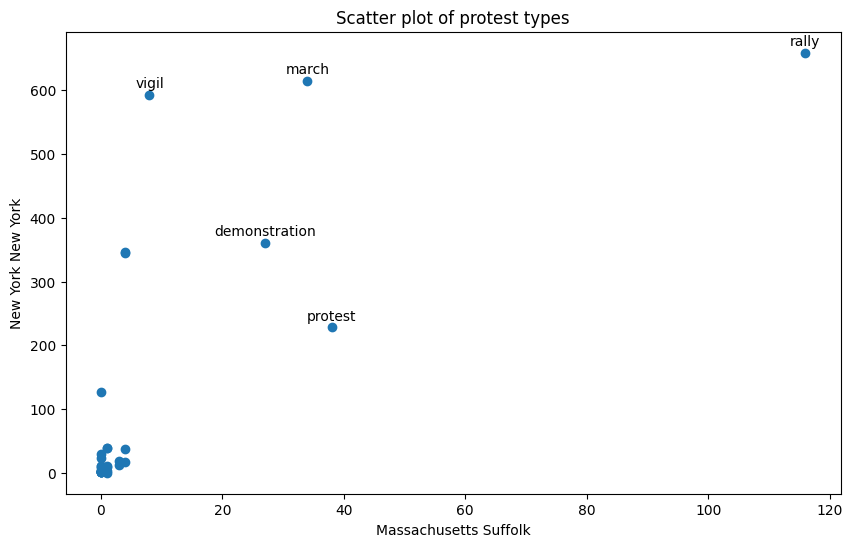

In [43]:
# Specifying the types to plot
label_types = ['rally', 'vigil', 'protest', 'demonstration','march']


plt.figure(figsize=(10, 6))
plt.scatter(pivoted_protest_type_counts['Massachusetts_Suffolk'], pivoted_protest_type_counts['New York_New York'])


for label_type in label_types:
    index = pivoted_protest_type_counts.index[pivoted_protest_type_counts['type'] == label_type].tolist()[0]
    plt.annotate(pivoted_protest_type_counts['type'][index], (pivoted_protest_type_counts['Massachusetts_Suffolk'][index], pivoted_protest_type_counts['New York_New York'][index]), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Scatter plot of protest types')
plt.xlabel('Massachusetts Suffolk')
plt.ylabel('New York New York')



plt.savefig('./output/comparision_chart_1.png', bbox_inches='tight', pad_inches=0.1)


I'm interested in the protest types that are super common in New york but not in Boston, like vigils. Almost 600 in new york but only 20 in Boston. Perhaps this is a population density issue. Now of course the scales are wildly different -- i wonder if any trends pop out when when take the log.

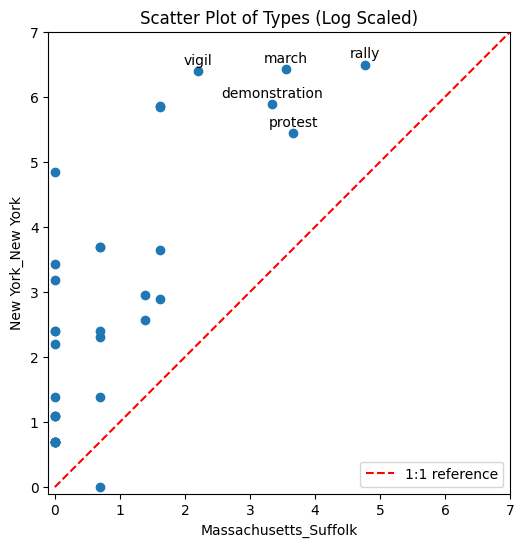

In [44]:

# Drop rows with missing values before log scaling (there shouldnt be any)
df = pivoted_protest_type_counts[['type', 'New York_New York', 'Massachusetts_Suffolk']].dropna()

# Log scaling
df_log = np.log1p(df[['New York_New York', 'Massachusetts_Suffolk']])

# Create the scatter plot using Matplotlib with log-scaled data
plt.figure(figsize=(10, 6))
plt.scatter(df_log['Massachusetts_Suffolk'], df_log['New York_New York'])

# Add labels for specified 'type' values
for label_type in label_types:
    index = df.index[df['type'] == label_type].tolist()[0]
    plt.annotate(df['type'][index], (df_log['Massachusetts_Suffolk'][index], df_log['New York_New York'][index]), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Scatter Plot of Types (Log Scaled)')
plt.xlabel('Massachusetts_Suffolk')
plt.ylabel('New York_New York')

plt.plot([0, 8], [0, 8], linestyle='--', color='red', label='1:1 reference')


# Set axis limits
plt.xlim(-0.1, 7)
plt.ylim(-0.1, 7)
plt.gca().set_aspect('equal')

plt.legend(loc='lower right')

plt.savefig('./output/comparision_chart_2.png', bbox_inches='tight', pad_inches=0.1)


Interesting, there might be some sort of exponential relationship here but certainly not super strong.

## What about time? 

we only have one year -- but maybe we can see interest temporal trends pull out. Just for clarity sake, I'm going to focus on those five protest types that seem to commonly occur in both areas.


I create a specific dataframe for this question focusing on three coulms. I count up each protest type for every unique combination of `['state_county','date','type']`

In [45]:
# Creating a specific dataframe for this problem
boston_ny_protests_time = boston_ny_protests[['state_county','date','type']]

# label_types is from the above problem
boston_ny_protests_time = boston_ny_protests_time[boston_ny_protests_time['type'].isin(label_types)]
boston_ny_protests_time['count'] = boston_ny_protests_time.groupby(['state_county', 'date', 'type'])['state_county'].transform('count')
boston_ny_protests_time.sort_values(by='date')

,state_county,date,type,count
477,New York_New York,2021-01-01,vigil,1
477,New York_New York,2021-01-01,march,1
479,New York_New York,2021-01-01,demonstration,2
480,New York_New York,2021-01-01,demonstration,2
484,New York_New York,2021-01-02,vigil,2
...,...,...,...,...
3030,New York_New York,2021-12-31,rally,1
3031,New York_New York,2021-12-31,vigil,2
3029,New York_New York,2021-12-31,vigil,2
3029,New York_New York,2021-12-31,march,1


Lets use plotly again to look at the events by type and date.

In [46]:

fig = px.scatter(boston_ny_protests_time, x='date', y='count', color='type',hover_data='state_county',
                 labels={'number_of_protests': 'Number of Protests'},
                 title='Protest Trends Over Time by Type')


fig.update_layout(height=800)

/opt/homebrew/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Obviously there is a lot of variance. There does seem to be two humps of activity. One in the spring and one in the fall. Maybe this has to do with the election -- but I wouldnt look too close into this data. There is a better way to visualize it.

I need to min-max scale this data just because there are a lot more protests in New York than boston. This will allow us to compare activity in each city on a reasonable scale

In [47]:
boston_ny_protests_time['count_scaled'] = (boston_ny_protests_time.
                                           groupby(['state_county', 'type'])['count'].
                                           transform(lambda x: (x - x.min()) / (x.max() - x.min())))
boston_ny_protests_time.head(2)

,state_county,date,type,count,count_scaled
5,Massachusetts_Suffolk,2021-07-01,rally,1,0.0
19,Massachusetts_Suffolk,2021-07-05,rally,1,0.0


In [48]:

fig = px.scatter(boston_ny_protests_time, x='date', y='count_scaled', color='type',symbol='state_county',
                 labels={'number_of_protests': 'Number of Protests'},
                 title='Protest Trends Over Time by Type')

fig.update_layout(height=800)

Okay this is somewhat more helpful. We can see there is a rough similarity in date of protest and type between cities. I'll make a final static graph that fits a non-linear smooth (via loess - although I would prefer a generalized additive model!) to the data further make the trend clearer.

I'll switch over to plotnine just for ease.

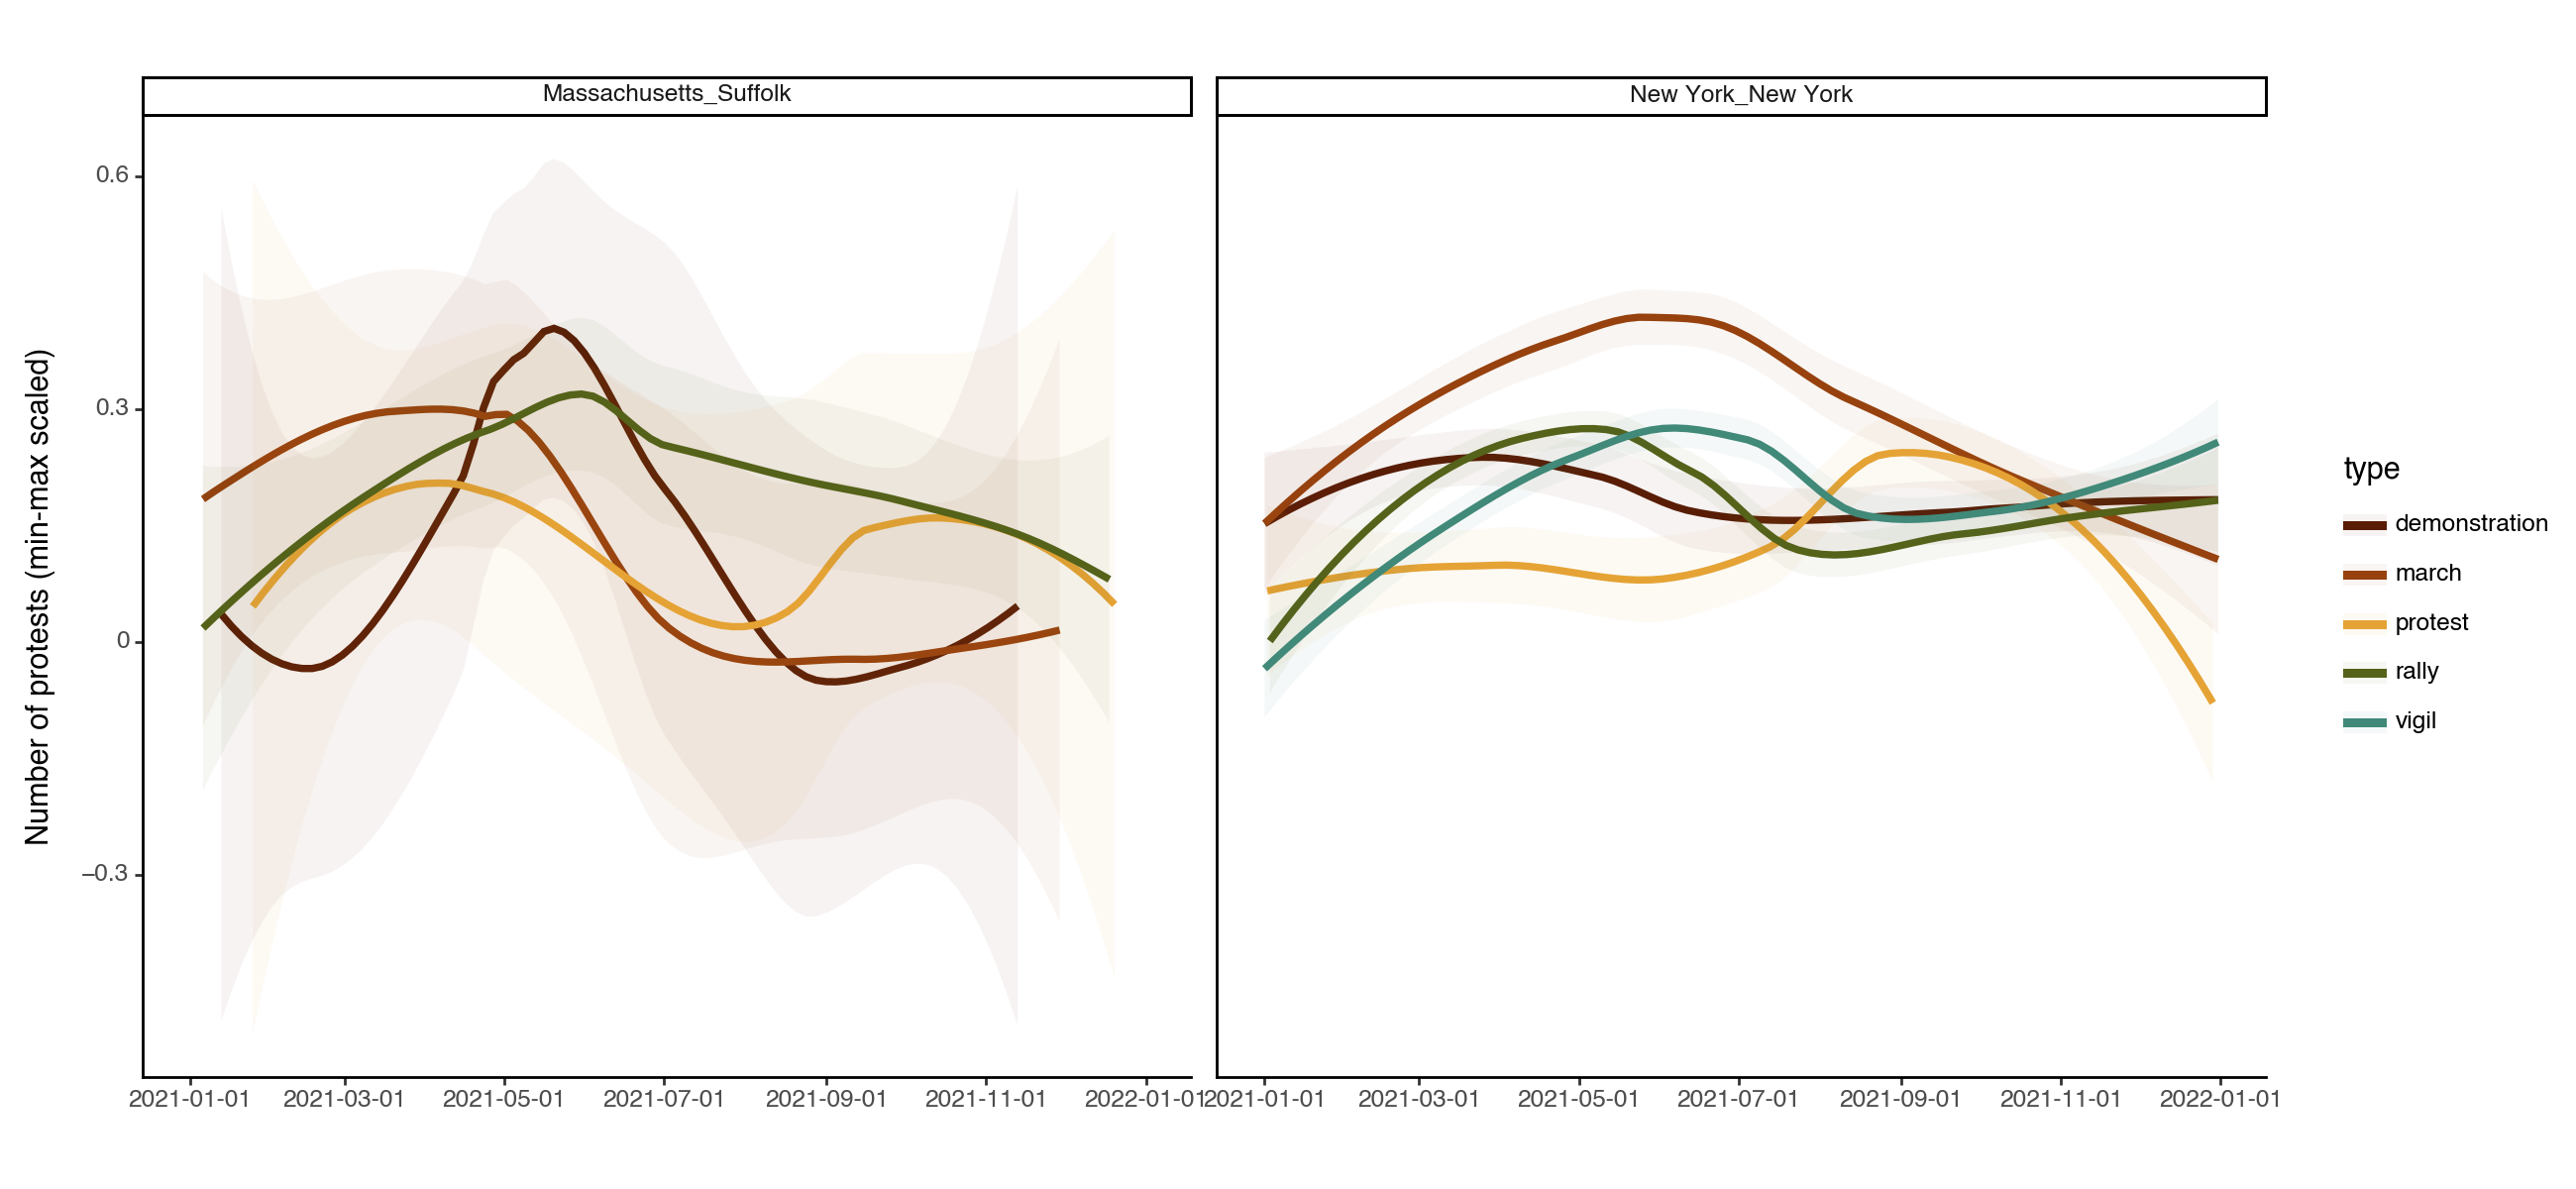

<Figure Size: (1300 x 600)>

In [49]:
pn.options.figure_size = (13, 6)

loess_smooth = (
    pn.ggplot(boston_ny_protests_time, pn.aes(x='date', y='count_scaled',color='type',fill='type'))
    + pn.geom_smooth(size=1.5,method='loess',se=True,alpha=0.05)
    + pn.scale_color_manual(values = ["#591d06", "#96410e", "#e5a335", "#556219", "#418979"])
    + pn.scale_fill_manual(values = ["#591d06", "#96410e", "#e5a335", "#556219", "#418979"])
    + pn.facet_wrap('state_county')
    + pn.theme_classic() 
    + pn.labs(y= "Number of protests (min-max scaled)", x = "")
)

loess_smooth

I'll write out the figure to disk.

In [50]:
loess_smooth2 = (loess_smooth + pn.theme_classic(base_size=10)) #Adjusting text size a little bit

loess_smooth2.save('./output/comparision_chart_3.png', verbose = False)

## Question 5 summary


So i've looked at the correlation between the number of protests by type in both locations. Overall New york has more incidences, however this might be a population density issue. There is not a strong 1:1 correlation between the two locations but more common protest types did stand out from the rest with rallies being the most obvious example. Over the year, there appears to be a similar trend with protests of all types in both location happening more in the spring.

# Question 6

### If you had more time, what else related to protest activity would you like to investigate with the datasets? (2-3 one-sentence bullet points)

* This was one years worth of data (2021) and an election year so it might be an outlier. I would be interested in see between year variations.
  
* I would like to compare this with large regional data. How does protests in the North East differ from the South West for example.

* I would be interested in seeing how this correlates with other security data violence for example since there likely is different trends between all the protest types. 

# Part 2: Geospatial Data Cleaning
#### Question 7

#### Using GeoPandas, please combine 'bozeman_data.parquet' and 'bozeman_multipolygon.geojson' to output a geojson file of Bozeman, Montana census tracts called 'bozeman_census_tracts.geojson'.

#### The 'bozeman_multipolygon.geojson' file is one multi-polygon that combines all polygons corresponding to the census tracts in 'bozeman_data.parquet'. The data in both files is in the same order.

#### For example, the first polygon of bozeman_multipolygon should be on the same row as the first row of bozeman_data.

#### Hint: start by creating a GeoDataFrame of 'bozeman_multipolygon.geojson'


I will start by importing all the data.


In [52]:
bozeman_data = pd.read_parquet('data/bozeman_data.parquet')
bozeman_geojson_data = gpd.read_file('data/bozeman_multipolygon.geojson')



`bozeman_data` is pretty straight forward -- just a parquet.

`bozeman_geojson_data` is not as straight forward. Its a multipolygon geojson in one row. I'll explode out the data so that each polygon has its own row. Then I'll create a `row_id` that matches the `bozeman_data.row_id` column.


In [53]:
bozeman_geojson_data = bozeman_geojson_data.explode(index_parts=True)
bozeman_geojson_data = bozeman_geojson_data.reset_index(drop=True)
bozeman_geojson_data['row_id'] = bozeman_geojson_data.index
bozeman_geojson_data = gpd.GeoDataFrame(bozeman_geojson_data, geometry='geometry')

I'll print out the data just to make sure everything looks okay

<Axes: >

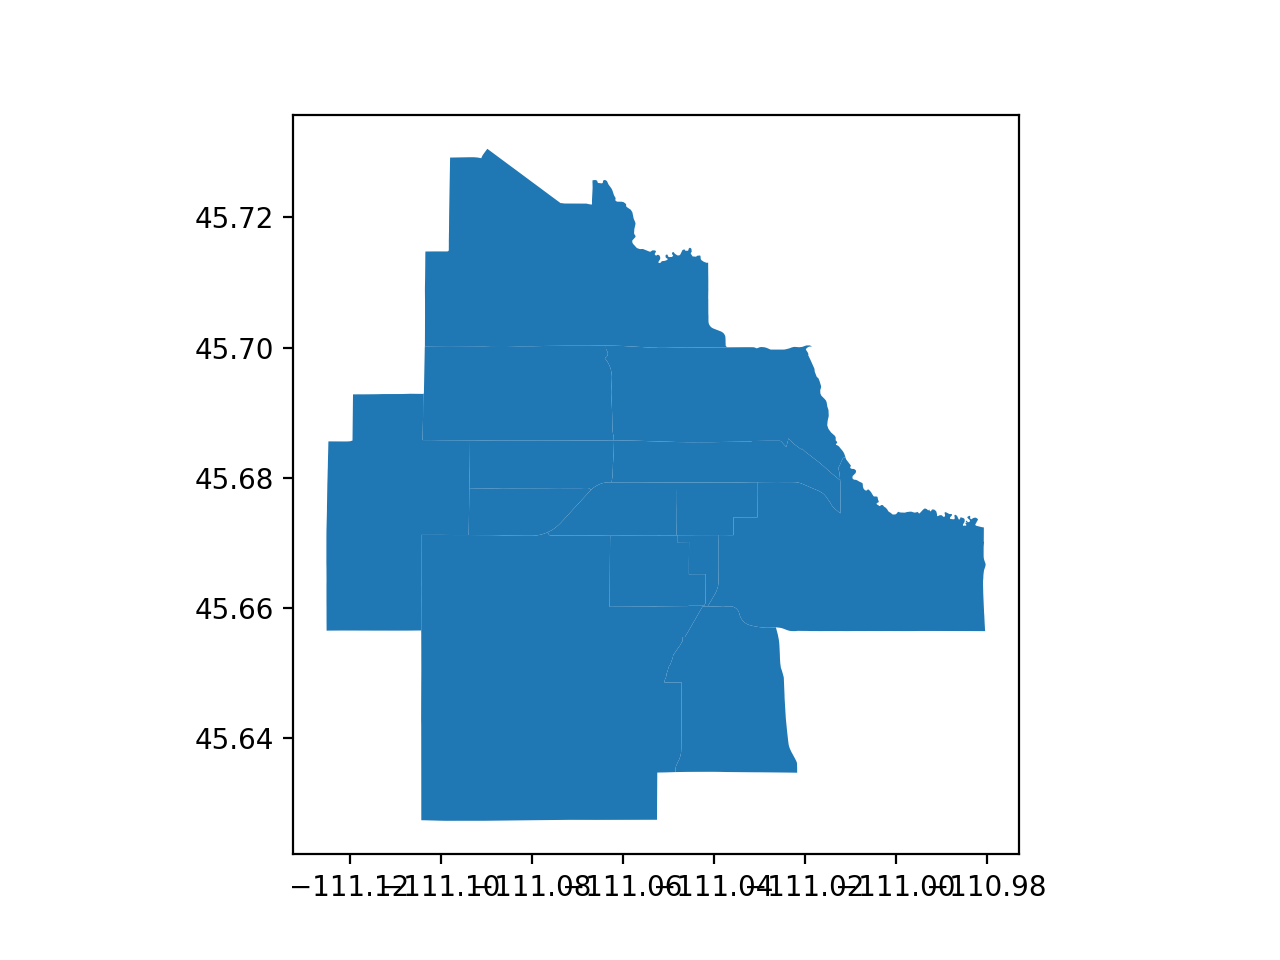

In [54]:
bozeman_data
bozeman_geojson_data
bozeman_geojson_data.plot()

Everything looks fine -- I make the assumption that both files are in order (as stated in the challenge), I will do a simple left join on `row_id.`

In [55]:
result = bozeman_geojson_data.merge(bozeman_data, on='row_id', how='left')
result

,geometry,row_id,location_name,display_name
0,"POLYGON ((-111.12509 45.66788, -111.12509 45.6...",0,"Bozeman, Gallatin County, Montana",Census Tract 5.05
1,"POLYGON ((-111.09380 45.67229, -111.09378 45.6...",1,"Bozeman, Gallatin County, Montana",Census Tract 7.03
2,"POLYGON ((-111.06359 45.69853, -111.06351 45.6...",2,"Bozeman, Gallatin County, Montana",Census Tract 6
3,"POLYGON ((-111.07641 45.67166, -111.07569 45.6...",3,"Bozeman, Gallatin County, Montana",Census Tract 9
4,"POLYGON ((-111.04811 45.67233, -111.04810 45.6...",4,"Bozeman, Gallatin County, Montana",Census Tract 8
5,"POLYGON ((-111.06241 45.67930, -111.06235 45.6...",5,"Bozeman, Gallatin County, Montana",Census Tract 7.01
6,"POLYGON ((-111.05078 45.64879, -111.05069 45.6...",6,"Bozeman, Gallatin County, Montana",Census Tract 10.01
7,"POLYGON ((-111.04121 45.66037, -111.04055 45.6...",7,"Bozeman, Gallatin County, Montana",Census Tract 10.02
8,"POLYGON ((-111.10393 45.68691, -111.10389 45.6...",8,"Bozeman, Gallatin County, Montana",Census Tract 5.06
9,"POLYGON ((-111.09366 45.67930, -111.09365 45.6...",9,"Bozeman, Gallatin County, Montana",Census Tract 7.04


Alright, lets write this out to disk

In [56]:
result.to_file("output/bozeman_census_tracts.geojson", driver="GeoJSON")